Tour 1: Length 270.2109621490428, Route: [0, 2, 4, 1, 9, 6, 0, 8]
Tour 2: Length 174.11263180727764, Route: [0, 3, 5, 7]
Total distance: 444.32359395632045
Execution time in seconds:  1.9159929752349854
Memory used:  176.586752 MB
Number of iterations: 41428
Cities:  10
Total trucks:  2
Capacities:  [7, 2]


C:\Users\Alexandre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


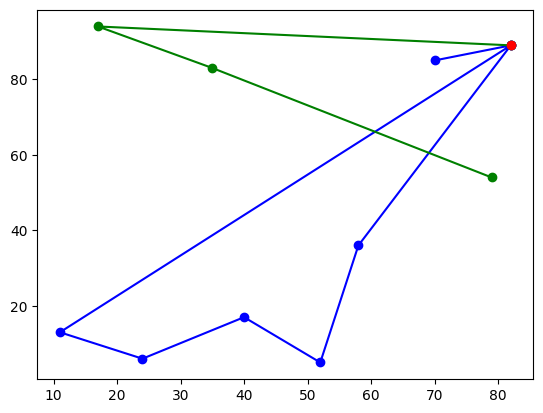

In [87]:
import numpy
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import psutil
import math
import time
from sklearn.cluster import KMeans

trucks = 2
city = 10


report_file = open("report.csv", "w")

def generate_truck_capacities(num_trucks, city):
    capacities = random.sample(range(1, 8), num_trucks)
    total_capacity = sum(capacities)

    while total_capacity < city-1:
        num_trucks += 1
        capacities.append(random.randint(1, 9))
        total_capacity = sum(capacities)

    return num_trucks, capacities

def read_dataset(filename):
    with open(filename) as fp:
        line = fp.readline()
        arr_city = []
        while line:
            xy = line.strip().split(";")
            xy = [float(e) for e in xy]
            # print(xy)
            arr_city.append(xy)
            line = fp.readline()

        return arr_city

def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / 1000000

def report(infos):
    report_file.write(infos + "\n")

def generate_cities(howmany=int(city), max_coordinates=100):
    return [random.sample(range(max_coordinates), 2) for _ in range(howmany)]

def generate_random_tour(cities):
    city_count = len(cities)
    return random.sample(range(city_count), city_count)

def split_tour(tour, num_trucks, cities, capacities):
    city_count = len(tour)

    # Créez une liste des coordonnées des villes
    city_coordinates = [cities[i] for i in tour]

    # Utilise K-means pour regrouper les villes en fonction de leur proximité géographique
    kmeans = KMeans(n_clusters=num_trucks, random_state=0).fit(city_coordinates)
    labels = kmeans.labels_

    sub_tours = [[] for _ in range(num_trucks)]
    for i, label in enumerate(labels):
        sub_tours[label].append(tour[i])

    # Ajoute le dépôt (ville 0) au début de chaque sous-tour
    for i in range(num_trucks):
        sub_tours[i].insert(0, 0)

    # Vérifie la capacité maximale de chaque camion et ajuste les tournées si nécessaire
    for i in range(num_trucks):
        while len(sub_tours[i]) - 2 > capacities[i]:  # Modifier la condition pour exclure la ville de départ
            # Trouve le camion avec une capacité suffisante pour prendre en charge la ville supplémentaire
            for j in range(num_trucks):
                if len(sub_tours[j]) - 2 < capacities[j]:  # Modifier également ici
                    # Transfère la dernière ville du camion i vers le camion j
                    sub_tours[j].append(sub_tours[i].pop(-2))  # Modifier également ici
                    break

    return sub_tours

def distance(tour, cities):
    distance = 0
    for i in range(1, len(tour)):
        distance += np.linalg.norm(np.array(cities[tour[i - 1]]) - np.array(cities[tour[i]]))
    distance += np.linalg.norm(np.array(cities[tour[-1]]) - np.array(cities[tour[0]]))
    return distance

def plot_tours(tours, cities):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, tour in enumerate(tours):
        tour_x = [cities[j][0] for j in tour]
        tour_y = [cities[j][1] for j in tour]
        plt.plot(tour_x, tour_y, colors[i % len(colors)] + 'o-')
    plt.plot(cities[0][0], cities[0][1], 'ro')  # depot in red
    plt.show()
    
def simulated_annealing(temp_init, cooling, temp_min):
    start_time = time.time()
    initial_temperature = temp_init
    cooling_rate = cooling
    nb_iterations = 0
    report("Iterations, Temperature, Best_Distance_Sans_Depot, current_distance, Time, Memory")

    cities = generate_cities()

    current_tour = generate_random_tour(cities)
    current_distance = distance(current_tour, cities)
    best_tour = current_tour
    best_distance = current_distance
    compteur = 2
    temperature = initial_temperature

    while temperature > temp_min:
        nb_iterations = nb_iterations + 1

        new_tour = copy.copy(current_tour)
        # Perform a random swap of two cities in the tour
        swap_indices = random.sample(range(1, len(new_tour)), 2)
        new_tour[swap_indices[0]], new_tour[swap_indices[1]] = new_tour[swap_indices[1]], new_tour[swap_indices[0]]

        new_distance = distance(new_tour, cities)
        delta_distance = new_distance - current_distance

        if delta_distance < 0 or random.random() < math.exp(-delta_distance / temperature):
            current_tour = new_tour
            current_distance = new_distance

        if current_distance < best_distance:
            best_tour = current_tour
            best_distance = current_distance
            # print(best_tour, best_distance)

        temperature *= cooling_rate
        if compteur > 0 and temperature < 0.001:
            temperature = 100
            compteur -= 1
        if nb_iterations % 200 == 0:
            time_to_write = time.time() - start_time
            report("{}, {}, {}, {}, {}, {}".format(nb_iterations, temperature, best_distance, current_distance, time_to_write,
                                                   print_memory_usage()))

    num_trucks, capacities = generate_truck_capacities(int(trucks), int(city))
    sub_tours = split_tour(best_tour, num_trucks, cities, capacities)

    total_distance = 0
    for i, sub_tour in enumerate(sub_tours):
        sub_tour_distance = distance(sub_tour, cities)
        print("Tour {}: Length {}, Route: {}".format(i + 1, sub_tour_distance, sub_tour))
        total_distance += sub_tour_distance

    print("Total distance: {}".format(total_distance))
    print("Execution time in seconds: ", time.time() - start_time)
    print("Memory used: ", print_memory_usage(), "MB")
    print("Number of iterations: {}".format(nb_iterations))
    print("Cities: ", city)
    print("Total trucks: ", num_trucks)
    print("Capacities: ", capacities)
    plot_tours(sub_tours, cities)

simulated_annealing(10000, 0.999, 0.0001)
